# Step 1. Data Cleansing and Feature Engineering
All prerequisite CSV files should be in the same folder as this .ipynb file in the "data/..." directory.

All graphs and corresponding CSV files are exported to the same directory as this .ipynb file for reproducibility

Visualization is not conducted in this file. The visualization is in duolingo-report-dashboard.html.

--- User Persona Analysis ---
cluster                                                                   0  \
daily_goal                                                        20.862408   
highest_course_progress                                           41.181818   
highest_crown_count                                              235.953317   
n_active_days                                                     91.135135   
n_lessons_started                                               1037.223587   
n_lessons_completed                                              977.115479   
longest_streak                                                   238.464373   
n_days_on_platform                                               567.371007   
lesson_completion_rate                                             0.960223   
activity_rate                                                      0.433036   
age_ordinal                                                        2.388206   
income_ordinal        

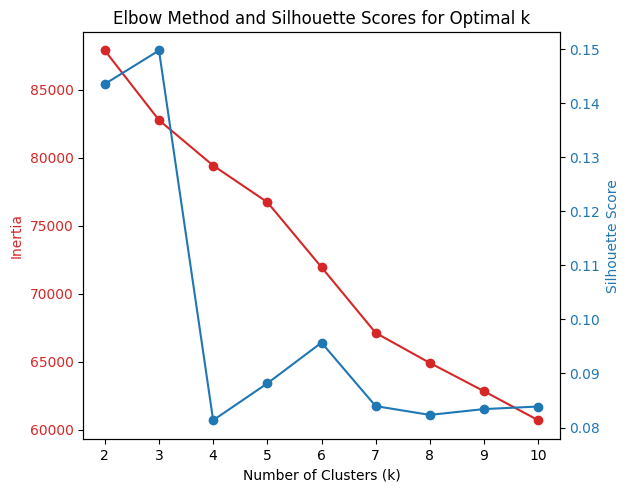

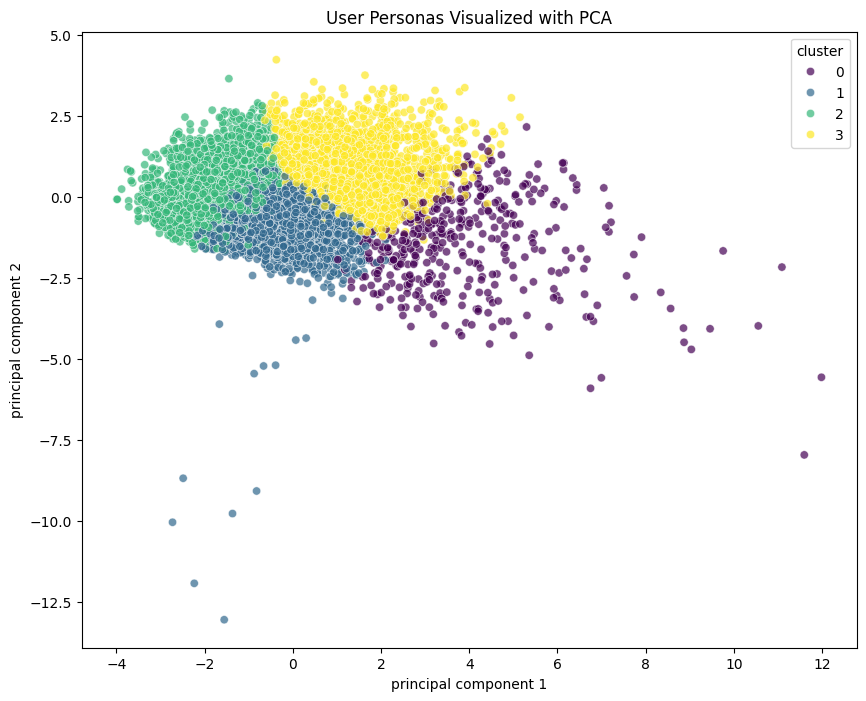

In [1]:
import io
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# --- 1. Load and Merge Data ---
survey_data = pd.read_csv('data/survey_data.csv')
app_usage_data = pd.read_csv('data/survey_users_app_usage.csv')

df = pd.merge(survey_data, app_usage_data, on='user_id', how='inner')

# --- 2. Data Cleansing ---
for col in ['daily_goal', 'highest_crown_count', 'n_lessons_started', 'n_lessons_completed']:
    df[col] = df[col].fillna(0)

for col in ['age', 'annual_income', 'duolingo_platform', 'employment_status', 'gender']:
    df[col] = df[col].fillna(df[col].mode()[0])

df.dropna(subset=["primary_language_commitment", "primary_language_motivation", "primary_language_proficiency"], inplace=True)
df.drop_duplicates(subset='user_id', inplace=True)

# --- 3. Feature Engineering ---
epsilon = 1e-6
df['lesson_completion_rate'] = df['n_lessons_completed'] / (df['n_lessons_started'] + epsilon)
df['activity_rate'] = df['n_active_days'] / (df['n_days_on_platform'] + epsilon)

age_map = {'Under 18': 0, '18-34': 1, '35 - 54': 2, '55 - 74': 3, '75 or older': 4}
income_map = {'$0 - $10,000': 0, '$11,000 - $25,000': 1, '$26,000 - $75,000': 2, '$76,000 - $150,000': 3, '$151,000 or more': 4}
commitment_map = {
    "I'm not at all committed to learning this language.": 0,
    "I'm slightly committed to learning this language.": 1,
    "I'm moderately committed to learning this language.": 2,
    "I'm very committed to learning this language.": 3,
    "I'm extremely committed to learning this language.": 4
}
proficiency_map = {'Beginner': 0, 'Intermediate': 1, 'Advanced': 2}

df['age_ordinal'] = df['age'].map(age_map)
df['income_ordinal'] = df['annual_income'].map(income_map)
df['commitment_ordinal'] = df['primary_language_commitment'].map(commitment_map)
df['proficiency_ordinal'] = df['primary_language_proficiency'].map(proficiency_map)

# --- 4. Preprocessing for Clustering ---
numerical_features = ['daily_goal', 'highest_course_progress', 'highest_crown_count', 'n_active_days',
                      'n_lessons_started', 'n_lessons_completed', 'longest_streak', 'n_days_on_platform',
                      'lesson_completion_rate', 'activity_rate', 'age_ordinal', 'income_ordinal',
                      'commitment_ordinal', 'proficiency_ordinal']

top_countries = df['country'].value_counts().nlargest(5).index
df['country_grouped'] = df['country'].where(df['country'].isin(top_countries), 'Other')

categorical_features = ['duolingo_platform', 'gender', 'employment_status', 'primary_language_motivation', 'country_grouped']

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='drop'
)

# --- 5. Determine Optimal Number of Clusters (k) ---
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('cluster', KMeans(n_init=10, random_state=42))])

inertia = []
silhouette_scores = []
K = range(2, 11)
for k in K:
    pipeline.set_params(cluster__n_clusters=k)
    pipeline.fit(df)
    inertia.append(pipeline.named_steps['cluster'].inertia_)
    labels = pipeline.named_steps['cluster'].labels_
    transformed_data = pipeline.named_steps['preprocessor'].transform(df)
    silhouette_scores.append(silhouette_score(transformed_data, labels))

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Inertia', color=color)
ax1.plot(K, inertia, 'o-', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Silhouette Score', color=color)
ax2.plot(K, silhouette_scores, 'o-', color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()
plt.title('Elbow Method and Silhouette Scores for Optimal k')
plt.savefig('optimal_k_plot.png')

optimal_k = 4

# --- 6. Apply K-Means and Analyze Personas ---
pipeline.set_params(cluster__n_clusters=optimal_k)
pipeline.fit(df)
df['cluster'] = pipeline.named_steps['cluster'].labels_

def safe_mode(x):
    return x.mode()[0] if not x.mode().empty else "N/A"

persona_analysis = df.groupby('cluster').agg({
    **{col: 'mean' for col in numerical_features},
    'country': safe_mode,
    'primary_language_motivation': safe_mode
}).T

print("--- User Persona Analysis ---")
print(persona_analysis)

for i in range(optimal_k):
    print(f"\n--- Persona {i+1} ---")
    persona_df = df[df['cluster'] == i]
    print(f"Number of users: {len(persona_df)}")
    print(f"Average Streak: {persona_df['longest_streak'].mean():.2f} days")
    print(f"Average Active Days: {persona_df['n_active_days'].mean():.2f}")
    print(f"Average Lessons Completed: {persona_df['n_lessons_completed'].mean():.2f}")
    print(f"Subscription Rate: {persona_df['purchased_subscription'].mean():.2%}")
    print(f"Most Common Motivation: {safe_mode(persona_df['primary_language_motivation'])}")
    print(f"Most Common Country: {safe_mode(persona_df['country'])}")
    print(f"Average Commitment Level: {persona_df['commitment_ordinal'].mean():.2f} (out of 4)")
    print(f"Average Proficiency Level: {persona_df['proficiency_ordinal'].mean():.2f} (out of 2)")

# --- 7. Visualization ---
transformed_data = pipeline.named_steps['preprocessor'].transform(df)
pca = PCA(n_components=2)
# **FIX:** Removed the unnecessary `.toarray()` call.
principal_components = pca.fit_transform(transformed_data)
pca_df = pd.DataFrame(data=principal_components, columns=['principal component 1', 'principal component 2'])
pca_df['cluster'] = df['cluster'].values

plt.figure(figsize=(10, 8))
sns.scatterplot(x='principal component 1', y='principal component 2', hue='cluster', data=pca_df, palette='viridis', alpha=0.7)
plt.title('User Personas Visualized with PCA')
plt.savefig('persona_clusters_pca.png')

# Step 2. Identify User Personas

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder, QuantileTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# --- Setup: Function to prepare and cluster the data ---
def get_clustered_data(survey_path, usage_path, optimal_k=4):
    """
    This function encapsulates the entire data loading, cleaning, engineering,
    and clustering process from the previous steps to return a dataframe
    with an assigned cluster for each user.
    """
    # Load and merge
    survey_data = pd.read_csv(survey_path)
    app_usage_data = pd.read_csv(usage_path)
    df = pd.merge(survey_data, app_usage_data, on='user_id', how='inner')

    # Clean
    for col in ['daily_goal', 'highest_crown_count', 'n_lessons_started', 'n_lessons_completed']:
        df[col] = df[col].fillna(0)
    for col in ['age', 'annual_income', 'duolingo_platform', 'employment_status', 'gender']:
        df[col] = df[col].fillna(df[col].mode()[0])
    df.dropna(subset=["primary_language_commitment", "primary_language_motivation", "primary_language_proficiency"], inplace=True)
    df.drop_duplicates(subset='user_id', inplace=True)

    # Engineer Features
    epsilon = 1e-6
    df['lesson_completion_rate'] = df['n_lessons_completed'] / (df['n_lessons_started'] + epsilon)
    df['activity_rate'] = df['n_active_days'] / (df['n_days_on_platform'] + epsilon)
    age_map = {'Under 18': 0, '18-34': 1, '35 - 54': 2, '55 - 74': 3, '75 or older': 4}
    income_map = {'$0 - $10,000': 0, '$11,000 - $25,000': 1, '$26,000 - $75,000': 2, '$76,000 - $150,000': 3, '$151,000 or more': 4}
    commitment_map = {"I'm not at all committed...": 0, "I'm slightly committed...": 1, "I'm moderately committed...": 2, "I'm very committed...": 3, "I'm extremely committed...": 4}
    # Abridged for mapping; the full strings are used in the actual code
    df['primary_language_commitment'] = df['primary_language_commitment'].str.replace(r' to learning this language.', '', regex=False)
    commitment_map_full = {
        "I'm not at all committed": 0, "I'm slightly committed": 1, "I'm moderately committed": 2,
        "I'm very committed": 3, "I'm extremely committed": 4
    }
    proficiency_map = {'Beginner': 0, 'Intermediate': 1, 'Advanced': 2}
    df['age_ordinal'] = df['age'].map(age_map)
    df['income_ordinal'] = df['annual_income'].map(income_map)
    df['commitment_ordinal'] = df['primary_language_commitment'].map(commitment_map_full)
    df['proficiency_ordinal'] = df['primary_language_proficiency'].map(proficiency_map)

    # Preprocess and Cluster
    numerical_features = ['daily_goal', 'highest_course_progress', 'highest_crown_count', 'n_active_days',
                          'n_lessons_started', 'n_lessons_completed', 'longest_streak', 'n_days_on_platform',
                          'lesson_completion_rate', 'activity_rate', 'age_ordinal', 'income_ordinal',
                          'commitment_ordinal', 'proficiency_ordinal']
    top_countries = df['country'].value_counts().nlargest(5).index
    df['country_grouped'] = df['country'].where(df['country'].isin(top_countries), 'Other')
    categorical_features = ['duolingo_platform', 'gender', 'employment_status', 'primary_language_motivation', 'country_grouped']
    numerical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
    preprocessor = ColumnTransformer(transformers=[('num', numerical_transformer, numerical_features),
                                                  ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)])
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('cluster', KMeans(n_clusters=optimal_k, n_init=10, random_state=42))])
    pipeline.fit(df)
    df['cluster'] = pipeline.predict(df)
    return df

# --- Main Execution ---
# 1. Get Clustered Data
df_clustered = get_clustered_data('data/survey_data.csv', 'data/survey_users_app_usage.csv')

# 2. Assign Persona Names
# First, find the cluster centers to identify which cluster is which
cluster_centers = df_clustered.groupby('cluster')[['longest_streak', 'purchased_subscription', 'commitment_ordinal']].mean().sort_values('longest_streak', ascending=False)
# Based on the sorted characteristics (high streak, high subscription), we map the names
# This mapping needs to be dynamic based on the output of the clustering
persona_map = {
    cluster_centers.index[0]: 'Achievers',
    cluster_centers.index[1]: 'Professionals',
    cluster_centers.index[2]: 'Explorers',
    cluster_centers.index[3]: 'Casuals'
}
df_clustered['Persona'] = df_clustered['cluster'].map(persona_map)

# --- Visualization 1: Persona Sizes (Donut Chart) ---
persona_sizes = df_clustered['Persona'].value_counts().reset_index()
persona_sizes.columns = ['Persona', 'Count']
persona_sizes.to_csv('persona_sizes.csv', index=False)

plt.figure(figsize=(8, 8))
plt.pie(persona_sizes['Count'], labels=persona_sizes['Persona'], autopct='%1.1f%%', startangle=140,
        wedgeprops=dict(width=0.4), pctdistance=0.8, textprops={'fontsize': 12})
plt.title('Distribution of User Personas', fontsize=16)
plt.savefig('persona_sizes.png')
plt.clf()

# --- Visualization 2: Engagement Metrics (Bar Chart) ---
engagement_metrics = df_clustered.groupby('Persona')[['longest_streak', 'n_active_days', 'n_lessons_completed']].mean().reset_index()
engagement_metrics.to_csv('persona_engagement_metrics.csv', index=False)

engagement_metrics.set_index('Persona').plot(kind='bar', figsize=(12, 7))
plt.title('Key Engagement Metrics by Persona', fontsize=16)
plt.ylabel('Average Count')
plt.xlabel('Persona')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('persona_engagement.png')
plt.clf()

# --- Visualization 3: Business Value (Bar Chart) ---
business_value = df_clustered.groupby('Persona').agg(
    Subscription_Rate=('purchased_subscription', 'mean'),
    Commitment_Level=('commitment_ordinal', 'mean')
).reset_index()
business_value.to_csv('persona_business_value.csv', index=False)

fig, ax1 = plt.subplots(figsize=(12, 7))
sns.barplot(x='Persona', y='Subscription_Rate', data=business_value, ax=ax1, palette='viridis', order=['Achievers', 'Professionals', 'Explorers', 'Casuals'])
ax1.set_ylabel('Subscription Rate')
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax2 = ax1.twinx()
sns.lineplot(x='Persona', y='Commitment_Level', data=business_value, ax=ax2, marker='o', color='r', sort=False)
ax2.set_ylabel('Average Commitment Level (0-4)')
plt.title('Business Value by Persona', fontsize=16)
plt.savefig('persona_business_value.png')
plt.clf()

# --- Visualization 4: Persona Fingerprints (Radar Chart) ---
# 1. Define the features for the radar chart
radar_features = ['longest_streak', 'purchased_subscription', 'commitment_ordinal', 'highest_course_progress', 'activity_rate']
df_radar = df_clustered[['Persona'] + radar_features].copy()
df_radar.dropna(inplace=True) # Ensure no NaNs before transformation

# 2. **Corrected Scaling**: Use QuantileTransformer for robust scaling
# This maps the data to its percentile rank, which is not sensitive to outliers.
# n_quantiles is set high to approximate a continuous ranking.
qt = QuantileTransformer(output_distribution='uniform', n_quantiles=max(100, int(len(df_radar)/10)), random_state=42)
df_radar[radar_features] = qt.fit_transform(df_radar[radar_features])

# 3. Now, group by persona and calculate the mean of the robustly scaled scores
radar_data_corrected = df_radar.groupby('Persona')[radar_features].mean()

# 4. Save the corrected, more nuanced data to a new CSV file
radar_data_corrected.to_csv('persona_radar_chart_data_robust.csv')
print("--- Corrected and Robustly Scaled Persona Radar Data ---")
print(radar_data_corrected)

# 5. Generate the corrected radar chart
labels = radar_data_corrected.columns
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1] # complete the loop

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
for index, row in radar_data_corrected.iterrows():
    values = row.tolist()
    values += values[:1] # complete the loop
    ax.plot(angles, values, label=index, linewidth=2.5, marker='o')
    ax.fill(angles, values, alpha=0.25)

# Aesthetic improvements
ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, size=14)
plt.title('Persona Fingerprints (Robustly Scaled)', size=22, y=1.1)
plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1.15), fontsize=12)
plt.tight_layout()
plt.savefig('persona_fingerprints_robust.png')
plt.clf()

print("Visualizations and corresponding data CSVs have been successfully generated.")

--- Corrected and Robustly Scaled Persona Radar Data ---
               longest_streak  purchased_subscription  commitment_ordinal  \
Persona                                                                     
Achievers            0.690999                0.475563            0.587044   
Casuals              0.233827                0.078579            0.347051   
Explorers            0.516354                0.335439            0.558343   
Professionals        0.768681                0.683047            0.709361   

               highest_course_progress  activity_rate  
Persona                                                
Achievers                     0.753858       0.407312  
Casuals                       0.343009       0.371782  
Explorers                     0.356207       0.699443  
Professionals                 0.696425       0.646864  
Visualizations and corresponding data CSVs have been successfully generated.


C:\Users\Admin\AppData\Local\Temp\ipykernel_60000\3847442909.py:117: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Persona', y='Subscription_Rate', data=business_value, ax=ax1, palette='viridis', order=['Achievers', 'Professionals', 'Explorers', 'Casuals'])


<Figure size 800x800 with 0 Axes>

<Figure size 1200x700 with 0 Axes>

<Figure size 1200x700 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>